# Part 2

## Which are the worst and best represented countries in the research?

In this section we convert the documents into a usable DataFrame in order to figure out the countries that are most and less active in the research.<br>

We do this by looking the country of the authors and the universities (affiliations).<br>


In [1]:
from dask.distributed import Client, LocalCluster, progress
import dask.bag as db
import dask

import json
import re

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### 3.2.1 Convert the documents in a usable DataFrame data structure

In [4]:
# Start a client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:59845 Dashboard: http://127.0.0.1:59846/status,Cluster Workers: 4 Cores: 4 Memory: 8.59 GB


In [5]:
# Load database with all .json files and repartition
b = db.read_text('data/papers_in_json_singleline/*.json').map(json.loads).repartition(npartitions=8)
b

dask.bag<repartition, npartitions=8>

As you can notice below, in the *metadata -> authors* fields there are many keys that are unnecessary for our purpose and we can drop.

In [13]:
b.pluck('metadata').take(1)

({'title': 'PfSWIB, a potential chromatin regulator for var gene regulation and parasite development in Plasmodium falciparum',
  'authors': [{'first': 'Wei-Feng',
    'middle': [],
    'last': 'Wang',
    'suffix': '',
    'affiliation': {'laboratory': '',
     'institution': 'Second Military Medical University',
     'location': {'postCode': '200433',
      'settlement': 'Shanghai',
      'country': 'China'}},
    'email': ''},
   {'first': 'Yi-Long',
    'middle': [],
    'last': 'Zhang',
    'suffix': '',
    'affiliation': {'laboratory': '',
     'institution': 'Second Military Medical University',
     'location': {'postCode': '200433',
      'settlement': 'Shanghai',
      'country': 'China'}},
    'email': ''}]},)

We notice that inside the *"author -> affiliation -> location -> country"* values there could be reported more than one country and we want to count all of them. In addition, sometimes the name of the country is repeated or is mispelled.<br>
For instance, China has the following synonims which should be counted as a single country: China, People's Republic of China, PR China, P.R. China.<br>

In the end, we find that the maximum number of countries for each author is two: for this reason we store the countries name (*"Country1"*, *"Country2"*) in a DataFrame along with the name and the university of each author.

In order to clean all the *country* entries before putting in the DataFrame, we develop two functions:<br>
- *clean_countries*: remove all the wrong characters (symbols, numbers, ...) using *RegEX* module as before, split if more than one country is reported and remove repetitions. It returns a list of two strings.
- *check_country_name*: correct the names in the list as in *"countries.txt"* format and check if the reported name is actually a country, otherwise insert None <br>

We have downloaded a database (*"countries.txt"*) containing the names of all the nations of the world, so we can use it to check that the information entered in *"author -> affiliation -> location -> country"* is actually the name of an existing country (i.e. New Jersey is not a country). <br>
We store it in cache memory in order to speed up the execution since it's a light database and it will be used many times.

In [2]:
# Caching database with correct name of all countries of the world
# Constructing this each time you call the function can be a bottleneck.
c_names = np.loadtxt('countries.txt', delimiter='\n', dtype=str)

In [4]:
# Check if the name of the country is in the database
# Or if the string contains a country
def check_country_name(country):
    if 'China' in country:
        return 'China'
    elif 'Brazil' in country:
        return 'Brasil'
    elif 'Netherlands' in country:
        return 'Netherlands'
    elif 'Korea' in country:
        return 'Korea'
    elif 'Oman' in country:
        return 'Oman'
    elif 'Congo' in country:
        return 'Congo'
    elif ('America' in country) or ('United States' in country):
        return 'USA'
    elif 'Russia' in country:
        return 'Russia'
    elif 'Singapore' in country:
        return 'Singapore'
    elif country == 'ROC':
        return 'Taiwan'
    elif country == 'Deutschland':
        return 'Germany'
    elif (country == 'United Kingdom') or (country == 'England') or ('UK' in country):
        return 'UK'
    elif country=='Schweden':
        return 'Sweden'
    elif country=='España':
        return 'Spain'
    # Check if it's in the database
    # i.e. if it really is a country and not a region, institution, ...
    elif country in c_names:
        return country
    else:
        return None

In [5]:
# 'Affiliation -> location -> country' may contain more than one contry
# there may also be some repeated countries
# or some random numbers, symbols or letters may be present
def clean_countries(countries):
    tmp = re.sub('[^,a-zA-Zñ ]', '', countries) # remove special characters except comma
    tmp = re.sub(r"\b[a-zA-Z]\b", "", tmp) # remove single letter
    tmp = tmp.split(', ') # split if more than one country is present
    tmp = [c.strip() for c in tmp] # remove leading and trailing spaces
    tmp = list(set(tmp)) # remove duplicates
    tmp = [check_country_name(c) for c in tmp]
    tmp = tmp + [None]*(2 - len(tmp)) # pad until size=2
    
    return tmp

In [7]:
# Store only name, countries and institution of each author
def flatten(record):
    
    # Retrieve institution
    if 'institution' in record['affiliation'].keys():
        institution = record['affiliation']['institution']
    else: institution = None
    
    # Retrieve location
    if 'location' in record['affiliation'].keys():
        if 'country' in record['affiliation']['location'].keys():
            # Retrieve array of countries
            countries = clean_countries(str(record['affiliation']['location']['country']))
            
        else: countries = [None] * 2
    else: countries = [None] * 2
    
    return {
        'Name':       record['first'],
        'Surname':    record['last'], 
        'University': institution,
        'Country1':   countries[0],
        'Country2':   countries[1]
    }

In [8]:
# Create Dask Dataframe with name, countries and institution of each author
df = (b.pluck('metadata').pluck('authors')
        .flatten()
        .map(flatten)
        .to_dataframe()
     )
df

,Name,Surname,University,Country1,Country2
npartitions=8,,,,,
,object,object,object,object,object
,...,...,...,...,...
...,...,...,...,...,...
,...,...,...,...,...
,...,...,...,...,...


In [9]:
df.head()

,Name,Surname,University,Country1,Country2
0,Wei-Feng,Wang,Second Military Medical University,China,None
1,Yi-Long,Zhang,Second Military Medical University,China,None
2,Chih-Cheng,Lai,Chi Mei Medical Center,Taiwan,None
3,Chen-Chen,Chu,National Taiwan University Hospital,Taiwan,None
4,Aristine,Cheng,New Taipei City,Taiwan,None


### 3.2.2 Figure out the countries that are most and less active in the research

Now we are ready for counting the country's occurrence: since the database has two columns with names of the nation, we have to merge the two counts.

In [10]:
# Count country's occurence in Country1 and Country2 columns
freq1 = df.Country1.value_counts()
freq2 = df.Country2.value_counts()

# Merge the two Dask Series
countries_freq = freq1.add(freq2, fill_value=0).astype(int)
countries_freq

Dask Series Structure:
npartitions=1
    int64
      ...
dtype: int64
Dask Name: astype, 2060 tasks

In [11]:
%%time
# Compute everything
countries_freq = countries_freq.compute().sort_values(ascending=False)

CPU times: user 2.51 s, sys: 128 ms, total: 2.64 s
Wall time: 6.82 s


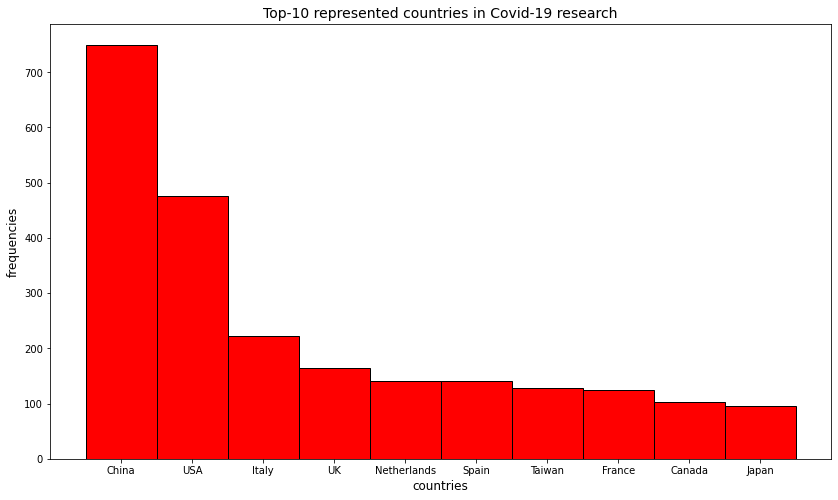

In [12]:
# Plot best represented countries
from matplotlib.ticker import MaxNLocator

plt.figure(figsize=(14,8))

pos = np.arange(10)
width = 1.0     # gives histogram aspect to the bar diagram

ax = plt.axes()
ax.set_xticks(pos)
ax.set_xticklabels(countries_freq.index[:10])

plt.bar(pos, countries_freq.values[:10], width, color='r', edgecolor='k')
plt.xlabel('countries', size=12)
plt.ylabel('frequencies', size=12)
plt.title('Top-10 represented countries in Covid-19 research', size=14)
plt.show()

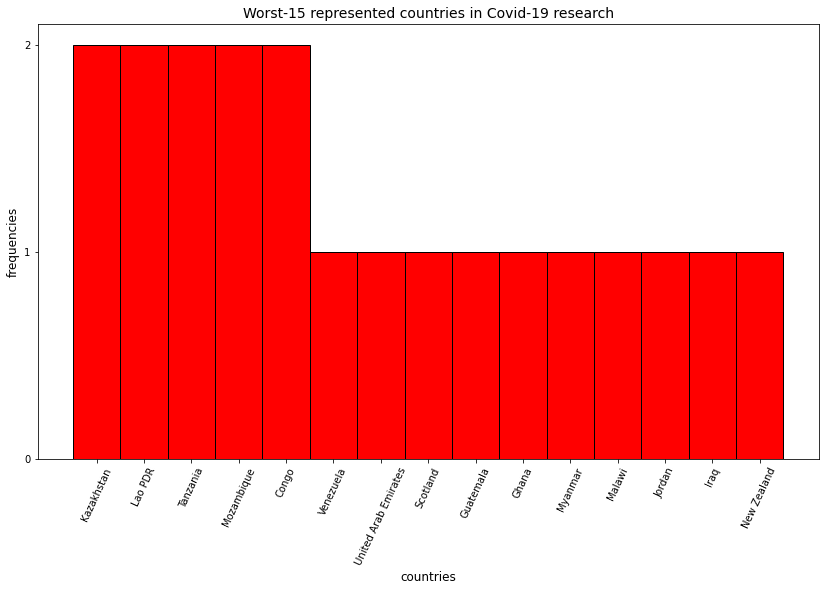

In [13]:
# Plot worst represented countries
plt.figure(figsize=(14,8))

m = 15 # number of countries to display
pos = np.arange(m)
width = 1.0     # gives histogram aspect to the bar diagram

ax = plt.axes()
ax.set_xticks(pos)
ax.set_xticklabels(countries_freq.index[-m:])
plt.xticks(rotation=65)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.bar(pos, countries_freq.values[-m:], width, color='r', edgecolor='k')
plt.xlabel('countries', size=12)
plt.ylabel('frequencies', size=12)
plt.title('Worst-15 represented countries in Covid-19 research', size=14)
plt.show()

### 3.2.3 Do the same for the universities

In [14]:
%%time
# Count institution's occurence
inst_freq = df.University.value_counts().compute()
inst_freq = inst_freq.drop('') # remove empty affiliation ("")

CPU times: user 2.46 s, sys: 109 ms, total: 2.57 s
Wall time: 6.47 s


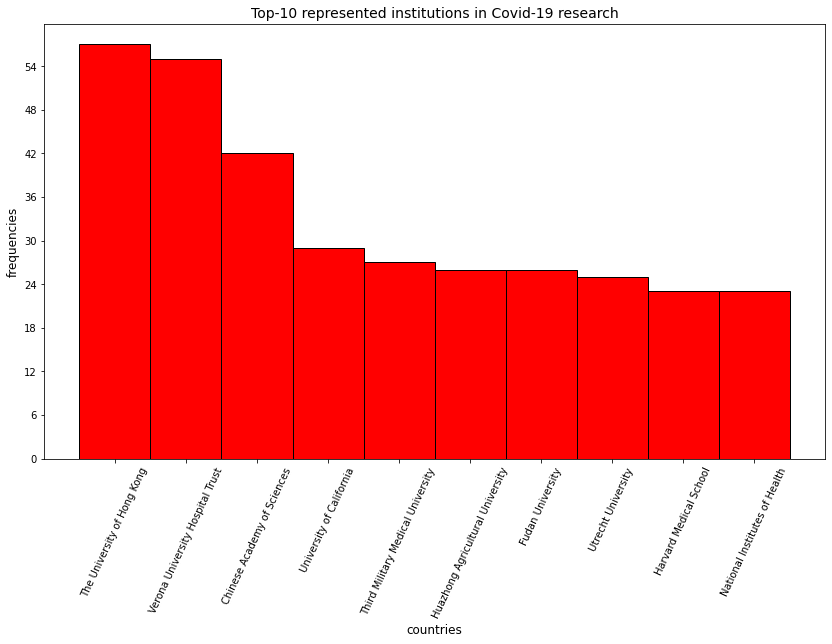

In [15]:
# Plot best represented universities
plt.figure(figsize=(14,8))

pos = np.arange(10)
width = 1.0     # gives histogram aspect to the bar diagram

ax = plt.axes()
ax.set_xticks(pos)
ax.set_xticklabels(inst_freq.index[:10])
plt.xticks(rotation=65)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.bar(pos, inst_freq.values[:10], width, color='r', edgecolor='k')
plt.xlabel('countries', size=12)
plt.ylabel('frequencies', size=12)
plt.title('Top-10 represented institutions in Covid-19 research', size=14)
plt.show()

In [16]:
# Print worst institutions
print('Worst institutions -> only one published paper\n')
print(inst_freq[inst_freq==1].index.tolist())

Worst institutions -> only one published paper

['Al-Quds University', "Wuxi Third People's Hospital", 'University of Mississippi Medical Center', 'Fred Hutchinson Cancer Research Center', 'Albert-Ludwigs-University', 'Free University Amsterdam', "Xi'an Jiaotong University", 'Genome Institute of Singapore', 'University of Macau', 'Gene Centre of LMU Munich', 'University of Malta', "University of Milan-Bicocca Piazza dell'Ateneo Nuovo", 'University of Messina', 'Alameda Prof. Hernâni Monteiro', "Wuxi Second People's Hospital", 'University of Massachusetts', 'University of Manitoba', 'Forman Christian College University', 'Utrecht 16 University', 'Althaia Network Health', 'Ev. Krankenhaus Herne und Augusta-Kranken-Anstalt', 'Edgefield Veterinary Clinic', 'Wellcome-Wolfson Institute for Experimental Medicine', 'Eduardo Mondlane University', 'Army Hospital Research and Referral', 'Eldridge Rd', 'Eliza Hall Institute of Medical Research', 'Emory University', 'University of New Mexico HSC', 

In [17]:
client.close()

### 3.2.3 Do multiple runs by changing the number of partitions and workers

One of the most crucial parameters in distributed and parallel computing is the number of partitions in which the dataset is divided. In order to study its effect on the calculation speed, we repeat the analysis shown above by changing the number of partitions.

In [18]:
import time

In [19]:
def compute_time(nwork=4, npart=8):
    myCluster = LocalCluster(n_workers=nwork)
    client = Client(myCluster)
    
    start = time.time()
    
    b = db.read_text('data/papers_in_json_singleline/*.json').map(json.loads).repartition(npartitions=npart)
    
    df = b.pluck('metadata').pluck('authors').flatten().map(flatten).to_dataframe()
    
    freq1 = df.Country1.value_counts()
    freq2 = df.Country2.value_counts()
    countries_freq = freq1.add(freq2, fill_value=0).astype(int)

    inst_freq = df.University.value_counts()
    
    (countries_freq, inst_freq) = dask.compute(countries_freq, inst_freq)
    inst_freq = inst_freq.drop('')
    
    end = time.time()
    
    client.close() #close client
    myCluster.close() #close cluster
    
    return end-start

In [20]:
parts = [1, 2, 4, 8, 16, 32, 64, 128]

timings_parts = np.zeros(len(parts))

for p in range(len(parts)):
    timings_parts[p] = compute_time(npart=parts[p])
    print("Partitions: ", parts[p], " time [s]: ", timings_parts[p])

Partitions:  1  time [s]:  15.974990367889404
Partitions:  2  time [s]:  10.908748149871826
Partitions:  4  time [s]:  9.14146876335144
Partitions:  8  time [s]:  8.093437910079956
Partitions:  16  time [s]:  7.900640249252319
Partitions:  32  time [s]:  8.60525369644165
Partitions:  64  time [s]:  9.312490463256836
Partitions:  128  time [s]:  9.237569332122803


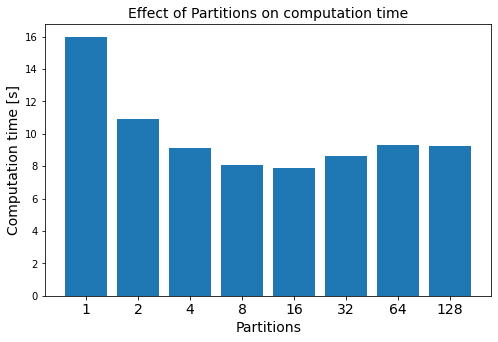

In [21]:
# Bar plot of Time vs Number of partitions

plt.figure(figsize=(8, 5))
plt.bar(range(len(parts)),timings_parts)
plt.title('Effect of Partitions on computation time',size=14)
plt.xlabel('Partitions',size=14)
plt.ylabel('Computation time [s]',size=14)
plt.xticks(range(len(parts)),parts,size=14)
plt.show()

We see with increasing partitions the computation time decreases thanks to parallelization, but after partition=16, the computation time increases again. There is a cost to having too many or having too few.

Partitions should fit comfortably in memory (smaller than a gigabyte) but also not be too many. Every operation on every partition takes the central scheduler a few hundred microseconds to process. If you have a few thousand tasks this is barely noticeable, but it is nice to reduce the number if possible.

## Grid Search:

Then, in order to see the performance of the algorithm as the cluster structure and the number of allocations vary, we implement a Grid-search by changing the number of workers and the number of partitions for each worker.

In [26]:
works = [1,2,3,4]
parts = [1,4,8,12,16]

timings = np.zeros((len(works),len(parts)))

for w in range(len(works)):
        for p in range(len(parts)):
            timings[w][p] = compute_time(works[w],parts[p]*works[w])
            print("workers: ", works[w], " partitions: ", parts[p]*works[w], " time [s]: ", timings[w][p])

workers:  1  partitions:  1  time [s]:  20.82198476791382
workers:  1  partitions:  4  time [s]:  12.760020971298218
workers:  1  partitions:  8  time [s]:  11.96391224861145
workers:  1  partitions:  12  time [s]:  10.598674535751343
workers:  1  partitions:  16  time [s]:  11.29230809211731
workers:  2  partitions:  2  time [s]:  13.907085180282593
workers:  2  partitions:  8  time [s]:  9.423659801483154
workers:  2  partitions:  16  time [s]:  8.737737655639648
workers:  2  partitions:  24  time [s]:  8.522927284240723
workers:  2  partitions:  32  time [s]:  9.556529760360718
workers:  3  partitions:  3  time [s]:  11.563644409179688
workers:  3  partitions:  12  time [s]:  8.994723320007324
workers:  3  partitions:  24  time [s]:  8.157195806503296
workers:  3  partitions:  36  time [s]:  9.168864965438843
workers:  3  partitions:  48  time [s]:  8.4654541015625
workers:  4  partitions:  4  time [s]:  10.076613187789917
workers:  4  partitions:  16  time [s]:  9.592581987380981
w

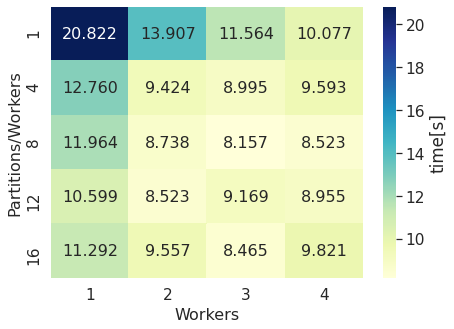

In [27]:
import seaborn as sns
df_cm = pd.DataFrame(timings.T, parts, works)


plt.figure(figsize=(7,5))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt=".3f",
           cbar_kws={'label':'time[s]'},cmap="YlGnBu")
plt.xlabel('Workers',fontsize=16)
plt.ylabel('Partitions/Workers',fontsize=16)
plt.show()

We see from the above mesh that 3 workers and 3 x 8 = 24 Partitions, are found to be optimal and has lesser computation time. We also notice that the number of workers and number of partitions have to be balanced i.e. not too small and not too many for both of them and so workers=3 and partition/workers = 8 looks more balanced and lies in the middle of the computation time grid.